In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
arquivo_raster = '/Users/marcelofernandes/My Drive/Arquivos/h_max_1.34953e+08_pacote100_090924.tif'

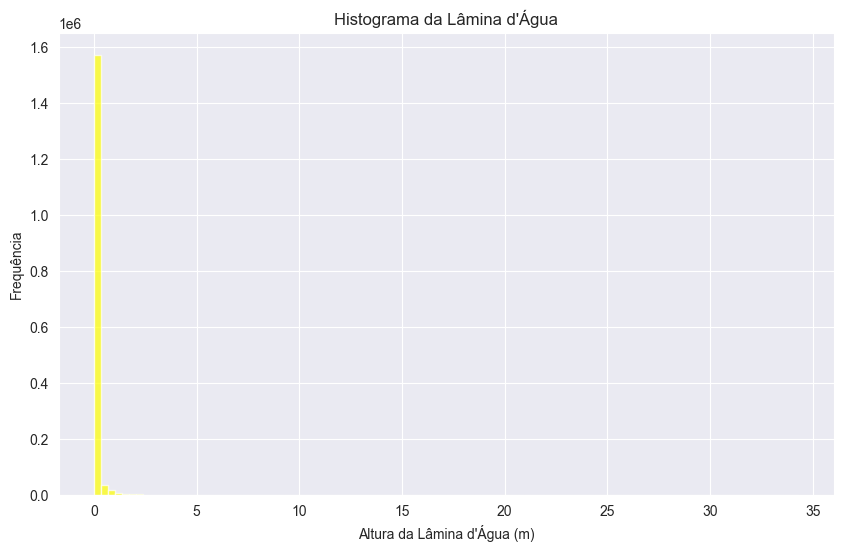

    Intervalo Inferior (m)  Intervalo Superior (m)  Frequência  Percentual (%)
0                 0.000000                0.343056     1571798         95.6496
1                 0.343056                0.686112       36206          2.2033
2                 0.686112                1.029168       15104          0.9191
3                 1.029168                1.372224        7175          0.4366
4                 1.372224                1.715280        3470          0.2112
..                     ...                     ...         ...             ...
95               32.590309               32.933365           0          0.0000
96               32.933365               33.276424           0          0.0000
97               33.276424               33.619480           0          0.0000
98               33.619480               33.962536           0          0.0000
99               33.962536               34.305592           2          0.0001

[100 rows x 4 columns]


In [3]:
# Definindo o limite de altura
limite_minimo = 0 # em metros
limite_maximo = 35 # em metros

# Número de intervalos (bins) do histograma
numero_bins = 100

# Abrindo o arquivo raster
with rasterio.open(arquivo_raster) as src:
    # Lendo a primeira banda do raster
    banda1 = src.read(1)

    # Obtendo o valor "NoData" do raster
    no_data_value = src.nodata
    
    # Criando uma máscara para filtrar os valores "NoData"
    if no_data_value is not None:
        mask = banda1 != no_data_value
        banda1 = banda1[mask]

    #Filtrando os valores acima de 30 cm e abaixo do limite máximo
    banda1_filtrada = banda1[(banda1 >= limite_minimo) & (banda1 <= limite_maximo)]

    # Criando o histograma
    plt.figure(figsize=(10, 6))
    plt.hist(banda1_filtrada.flatten(), bins=numero_bins, color='yellow', alpha=0.7)
    plt.title('Histograma da Lâmina d\'Água')
    plt.xlabel('Altura da Lâmina d\'Água (m)')
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()
    
    # Gerando o histograma
    counts, bin_edges = np.histogram(banda1_filtrada, bins=numero_bins)
    
    # Calculando o percentual de cada intervalo em relação ao total de pixels filtrados
    total_pixels = counts.sum()
    porcentagens = np.round((counts / total_pixels) * 100,4) # Formatando para quatro casas decimais
    
    # Criando a tabela com os dados do histograma
    tabela_histograma = pd.DataFrame({
        'Intervalo Inferior (m)': bin_edges[:-1],
        'Intervalo Superior (m)': bin_edges[1:],
        'Frequência': counts,
        'Percentual (%)': porcentagens
    })

    # Exibindo a tabela
    print(tabela_histograma)

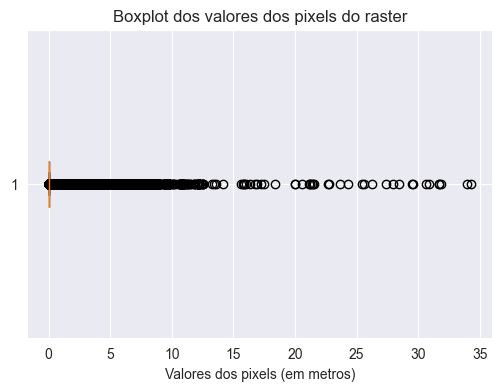

In [4]:
# Transformar o raster em uma lista de valores (1D) para criar o boxplot
pixel_values = banda1_filtrada.flatten()

# Criar o boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(pixel_values, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Boxplot dos valores dos pixels do raster")
plt.xlabel("Valores dos pixels (em metros)")
plt.show()

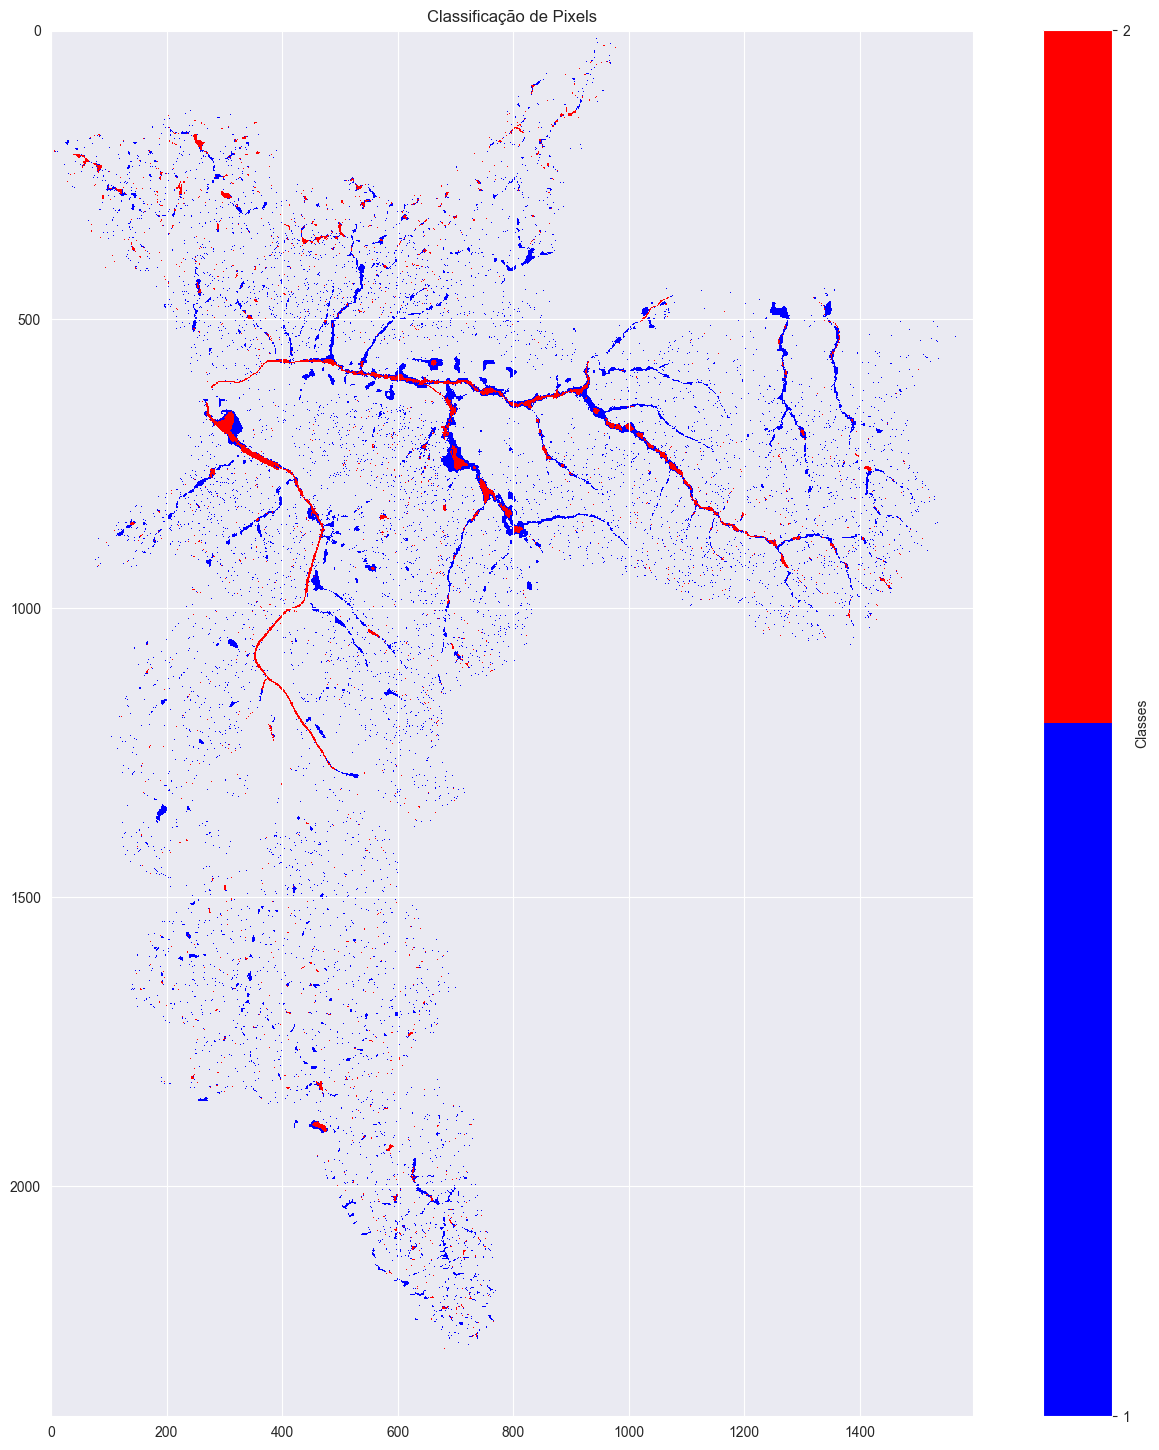

In [5]:
from matplotlib.colors import ListedColormap

# Abrindo o arquivo raster
with rasterio.open(arquivo_raster) as src:
    # Lendo a primeira banda do raster
    banda1 = src.read(1)

    # Obtendo o valor "NoData" do raster
    no_data_value = src.nodata
    
    # O erro TypeError: Invalid shape (1643290,) for image data ocorre porque, após aplicar a máscara banda1 = banda1[mask], o array resultante (banda1) se torna unidimensional (1D), mas a função plt.imshow() espera uma matriz 2D para visualizar corretamente uma imagem raster.
    
    # Criando uma máscara para filtrar os valores "NoData"
    if no_data_value is not None:
        mask = banda1 != no_data_value
    else:
        mask = np.ones_like(banda1, dtype=bool)  # Se não houver valor NoData, considerar todos os valores
    
    # Aplicar máscara para garantir que apenas valores válidos sejam considerados
    banda1_filtrada = np.where(mask, banda1, np.nan)  # Colocar NaN onde há NoData
    
   # Criar uma matriz de classificação
    classified_pixels = np.full(banda1_filtrada.shape, np.nan)  # Matriz vazia com NaN

    # Pixels entre 1m e 2m serão classificados como 1
    classified_pixels[(banda1_filtrada > 0.3) & (banda1_filtrada <= 1)] = 1

    # Pixels maiores que 2m serão classificados como 2
    classified_pixels[banda1_filtrada > 1] = 2

    # Criar um colormap personalizado
    cmap = ListedColormap(['blue', 'red'])  # Azul para classe 1, Vermelho para classe 2
    
    # Plotar o gráfico
    plt.figure(figsize=(18, 18))
    plt.imshow(classified_pixels, cmap=cmap, interpolation='none')
    plt.colorbar(ticks=[1, 2], label='Classes')  # Definir as classes no colorbar
    plt.title('Classificação de Pixels')
    
    # Exibir o gráfico
    plt.show()

In [11]:
# Filtragem dos outliers
# Referências:
# https://github.com/MeteHanC/Python-Median-Filter
# Explicação do ChatGPT:
# Filtro de Mediana (Altamente Recomendado)
#O filtro de mediana é particularmente útil para remover pequenos artefatos e ruídos sem alterar significativamente os valores importantes da imagem, como áreas de alagamento ou estruturas urbanas.
#Por que é útil?: A mediana preserva os detalhes das bordas e não é tão suscetível a valores extremos (outliers). Em áreas urbanas, onde os padrões de elevação e água podem variar drasticamente de pixel para pixel, a mediana pode suavizar inconsistências sem apagar dados críticos, como pequenos pontos de alagamento.

from scipy.ndimage import median_filter

# Aplica filtro de mediana com uma janela 3x3
banda1_filtrada_mediana = median_filter(banda1_filtrada, size=3)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipyk

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

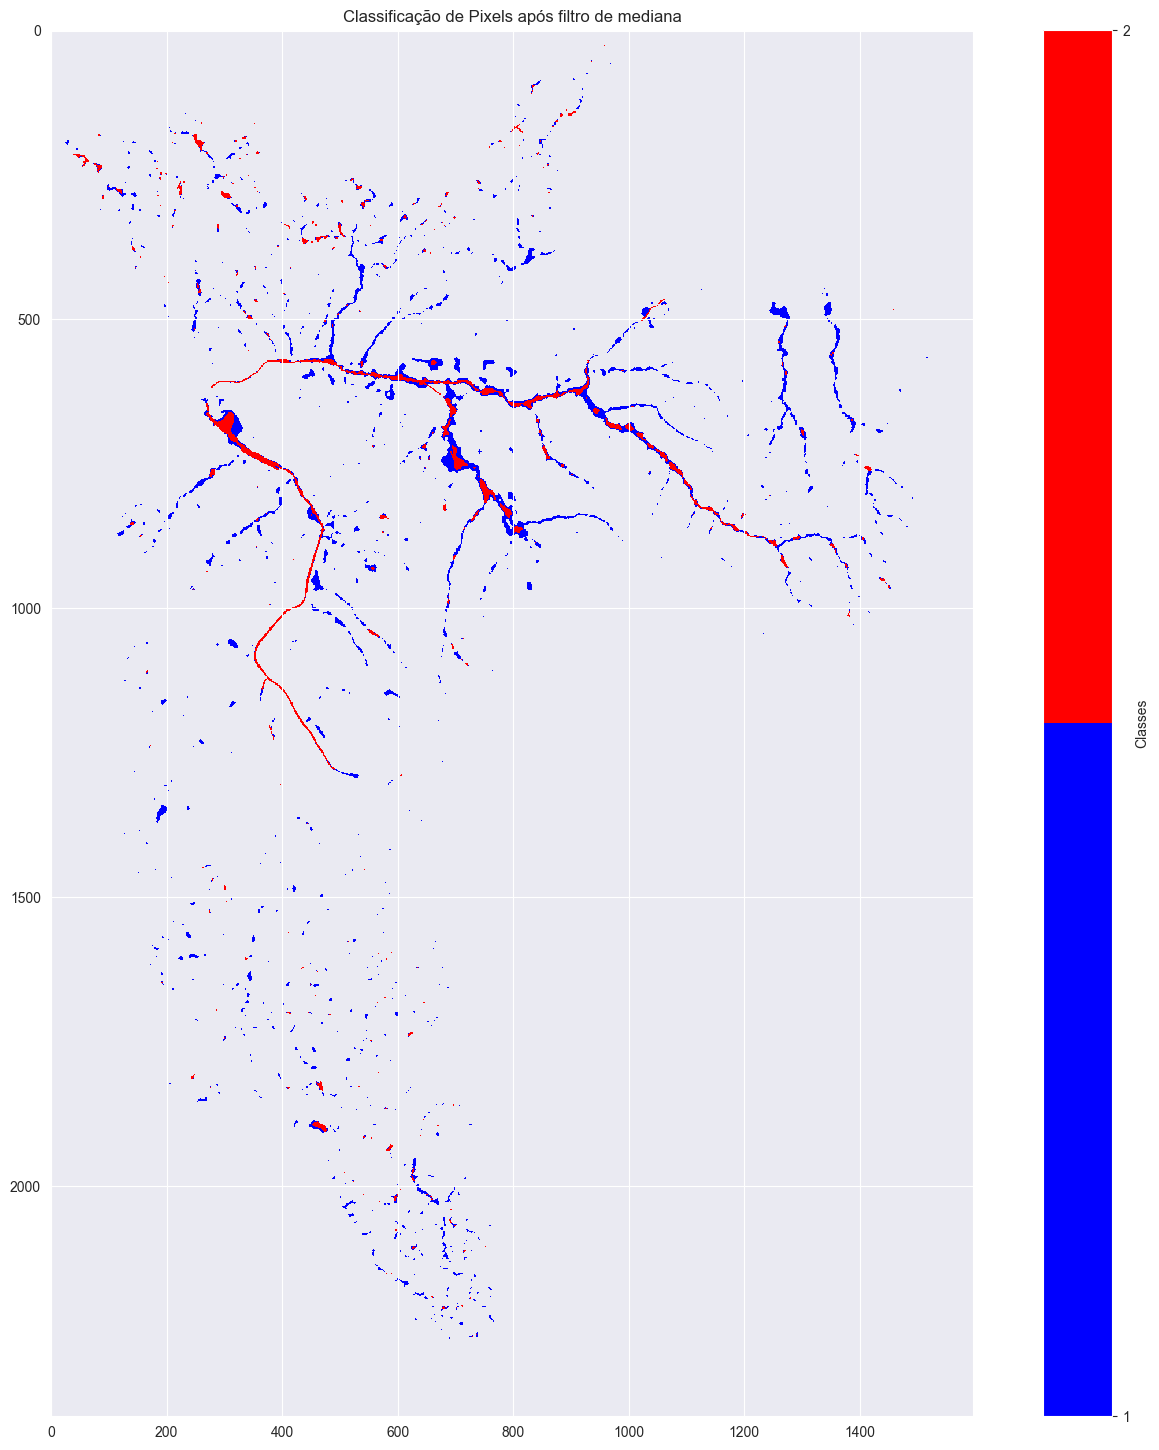

In [114]:
# Criar uma matriz de classificação
classified_pixels_mediana = np.full(banda1_filtrada_mediana.shape, np.nan)  # Matriz vazia com NaN

# Pixels entre 1m e 2m serão classificados como 1
classified_pixels_mediana[(banda1_filtrada_mediana > 0.3) & (banda1_filtrada_mediana <= 1)] = 1

# Pixels maiores que 2m serão classificados como 2
classified_pixels_mediana[banda1_filtrada_mediana > 1] = 2

# Criar um colormap personalizado
cmap = ListedColormap(['blue', 'red'])  # Azul para classe 1, Vermelho para classe 2
    
# Plotar o gráfico
plt.figure(figsize=(18, 18))
plt.imshow(classified_pixels_mediana, cmap=cmap, interpolation='none')
plt.colorbar(ticks=[1, 2], label='Classes')  # Definir as classes no colorbar
plt.title('Classificação de Pixels após filtro de mediana')
    
# Exibir o gráfico
plt.show()

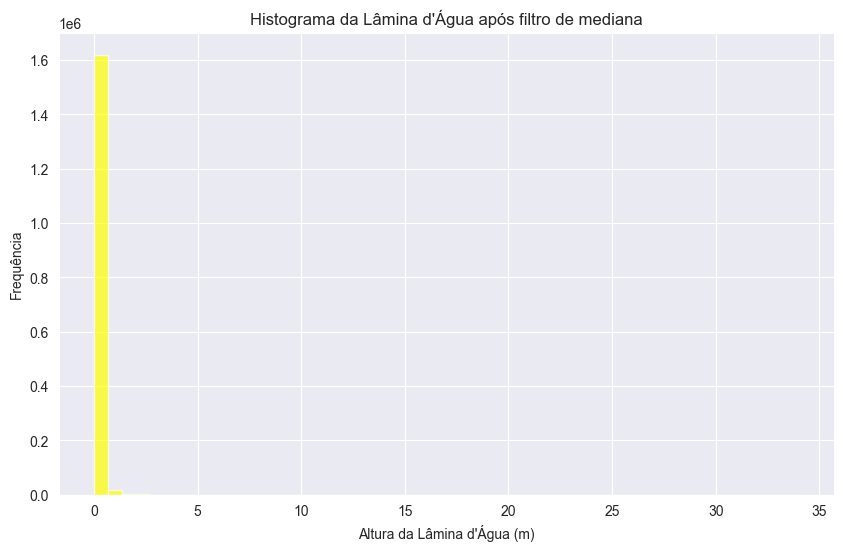

    Intervalo Inferior (m)  Intervalo Superior (m)  Frequência  Percentual (%)
0                 0.000000                0.339922     1596265         97.0314
1                 0.339922                0.679843       22715          1.3808
2                 0.679843                1.019765       10628          0.6460
3                 1.019765                1.359687        5351          0.3253
4                 1.359687                1.699608        2677          0.1627
..                     ...                     ...         ...             ...
95               32.292561               32.632481           0          0.0000
96               32.632481               32.972404           0          0.0000
97               32.972404               33.312325           0          0.0000
98               33.312325               33.652248           0          0.0000
99               33.652248               33.992168           2          0.0001

[100 rows x 4 columns]


In [122]:
# Criando o histograma
plt.figure(figsize=(10, 6))
plt.hist(banda1_filtrada_mediana.flatten(), bins=numero_bins, color='yellow', alpha=0.7)
plt.title('Histograma da Lâmina d\'Água após filtro de mediana')
plt.xlabel('Altura da Lâmina d\'Água (m)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()
  
# Número de intervalos (bins) do histograma
numero_bins = 100

# Remover valores NaN
banda1_filtrada_mediana_2 = banda1_filtrada_mediana[~np.isnan(banda1_filtrada_mediana)]

# Gerando o histograma
counts, bin_edges = np.histogram(banda1_filtrada_mediana_2, bins=numero_bins)
    
# Calculando o percentual de cada intervalo em relação ao total de pixels filtrados
total_pixels = counts.sum()
porcentagens = np.round((counts / total_pixels) * 100,4) # Formatando para quatro casas decimais
    
# Criando a tabela com os dados do histograma
tabela_histograma = pd.DataFrame({
        'Intervalo Inferior (m)': bin_edges[:-1],
        'Intervalo Superior (m)': bin_edges[1:],
        'Frequência': counts,
        'Percentual (%)': porcentagens
    })

# Exibindo a tabela
print(tabela_histograma)

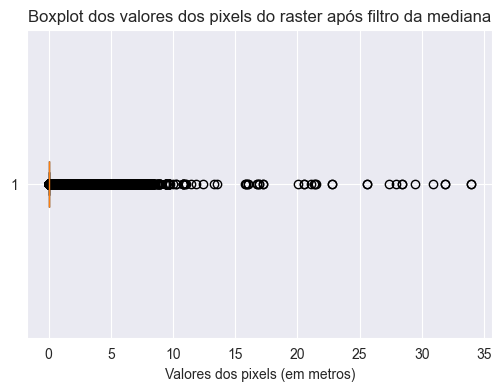

In [106]:
# Transformar o raster em uma lista de valores (1D) para criar o boxplot
pixel_values2 = banda1_filtrada_mediana_2.flatten()

# Criar o boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(pixel_values2, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Boxplot dos valores dos pixels do raster após filtro da mediana")
plt.xlabel("Valores dos pixels (em metros)")
plt.show()

In [4]:
import rasterio
import numpy as np

# Abrir o georaster
with rasterio.open(arquivo_raster) as dataset:
    # Ler o conteúdo do raster
    raster_data = dataset.read(1)  # Leitura da primeira banda
    
    # Aplicar a limitação de valor máximo a 0.34
    raster_data = np.minimum(raster_data, 0.34)

    # Perfil (metadados) do arquivo original para manter georreferenciamento
    profile = dataset.profile

# Escrever a nova imagem com o valor limitado
with rasterio.open('georaster_modificado.tif', 'w', **profile) as dst:
    dst.write(raster_data, 1)  # Gravar na primeira banda

In [6]:
numero_bins = 30

# Transformar o raster em uma lista de valores (1D) para criar o boxplot
pixel_values2 = raster_data.flatten()

# Gerando o histograma
counts, bin_edges = np.histogram(pixel_values2, bins=numero_bins)
    
# Calculando o percentual de cada intervalo em relação ao total de pixels filtrados
total_pixels = counts.sum()
porcentagens = np.round((counts / total_pixels) * 100,4) # Formatando para quatro casas decimais
    
# Criando a tabela com os dados do histograma
tabela_histograma = pd.DataFrame({
        'Intervalo Inferior (m)': bin_edges[:-1],
        'Intervalo Superior (m)': bin_edges[1:],
        'Frequência': counts,
        'Percentual (%)': porcentagens
    })

# Exibindo a tabela
print(tabela_histograma)

    Intervalo Inferior (m)  Intervalo Superior (m)  Frequência  Percentual (%)
0             -9999.000000            -9665.688477     2187913         57.1077
1             -9665.688477            -9332.376953           0          0.0000
2             -9332.376953            -8999.066406           0          0.0000
3             -8999.066406            -8665.754883           0          0.0000
4             -8665.754883            -8332.443359           0          0.0000
5             -8332.443359            -7999.131836           0          0.0000
6             -7999.131836            -7665.820312           0          0.0000
7             -7665.820312            -7332.509277           0          0.0000
8             -7332.509277            -6999.198242           0          0.0000
9             -6999.198242            -6665.886719           0          0.0000
10            -6665.886719            -6332.575195           0          0.0000
11            -6332.575195            -5999.263672  